In [2]:
#
# This section taken from MaterialsAutomated0-CurieWeiss
#
import logging
import csv

# Section aware importer of a PPMS data file
def readPPMSDataFile(file):
    rv = {}
    with open(file, newline="") as f:
        r = csv.reader(f,delimiter=',')
        hdr = []
        data = []
        section = None
        for l in r:
            if len(l) > 0:
                if l[0].lower() == '[Header]'.lower():
                    section = hdr
                elif l[0].lower() == '[Data]'.lower():
                    section = data
                elif len(l[0]) > 0 and l[0][0] == ';':
                    pass # ignore commented out lines
                elif section != None:
                    section.append(l)
                else:
                    logging.warning("No section yet defined for line: %s", l)
            else:
                logging.info("Ignoring empty line: %s", l)
        rv['header'] = hdr
        rv['data'] = data
    return rv

# Get the names of all the header variables
def getHeaders(fileData):
    rv = None
    if 'header' in fileData:
        rv = []
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            rv.append(l[0])
    return rv
   
# Get the value of a named header variable
def getHeaderValue(fileData, name):
    rv = None
    if 'header' in fileData:
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            if l[0].lower() == name.lower():
                if len(l) > 1:
                    val = ''.join(l[1:])
                else:
                    val = ''
                if rv is None:
                    rv = []
                rv.append(val)
    if (len(rv) > 1):
        return rv
    return rv[0]

# Get the names of the available data columns
def getDataColumns(fileData):
    rv = None
    if 'data' in fileData and len(fileData['data']) > 0:
        rv = fileData['data'][0]
    return rv

# Get the entries stored in one data column
def getDataColumn(fileData, name, prefixMatching=True):
    rv = None
    if 'data' in fileData:
        headers = None
        nameIndex = None
        headerName = None
        for l in fileData['data']:
            if headers is None:
                headers = l
                for i,h in enumerate(headers):
                    if ((prefixMatching and len(h) >= len(name) and h[0:len(name)].lower() == name.lower()) or
                       (not prefixMatching and h.lower() == name.lower())):
                        if nameIndex is None:
                            nameIndex = i
                            headerName = h
                            rv = []
                        else:
                            logging.warning("Ambiguous column selected: %s and %s both match %s", headerName, h, name)
            elif nameIndex != None:
                if len(l) > nameIndex:
                    try:
                        rv.append(float(l[nameIndex]))
                    except ValueError:
                        rv.append(l[nameIndex])
                else:
                    rv.append(None)
                    logging.warning("Unusually short line in data section: %s", l)
    return rv

In [3]:
import numpy as np
from math import sqrt
#
# Often time specific heat data is collected in duplicate. This function
# takes as input temp, cp, and optionally cp_err columns and outputs
# a condensed/averaged dataset with proper propagation of error
# (assuming independent random errors, and with a minor sin regarding
# combining the sample std dev estimator with the individual point std dev's)
#
# temp_tol is the % temperature difference within with different measurements are considered to be "the same"
# set to 1%, a typical semi-adiabatic temperature rise
#
def mergeCp(temp,cp,cp_err=None,temp_tol=0.01):
    if cp_err is None:
        cp_err = np.ones(cp.shape)
    rv = []
    lT = temp[0]
    lCp = cp[0]
    lCpss = 0
    lCpe = cp_err[0]*cp_err[0]
    lnum = 1
    for i in range(1,len(temp)):
        if (temp[i]-lT)/lT < temp_tol:
            # same temperature, merge
            # compute running averages, etc, with Welford's algorithm
            lnum += 1
            lT = lT + (temp[i]-lT)/lnum
            # must compute sum squares update before updating mean
            lCpnew = lCp + (cp[i]-lCp)/lnum
            lCpss = lCpss + (cp[i]-lCp)*(cp[i]-lCpnew)
            lCp = lCpnew
            lCpe += cp_err[i]*cp_err[i]
        else:
            # new temperature, no merge
            rv.append([lT,lCp,sqrt((lCpss+lCpe)/lnum)])
            lT = temp[i]
            lCp = cp[i]
            lCpss = 0
            lCpe = cp_err[i]*cp_err[i]
            lnum = 1
    # wrap up last one
    rv.append([lT,lCp,sqrt((lCpss+lCpe)/lnum)])
    return np.transpose(np.array(rv))

In [4]:
def DataCleanTransform(temp,cp,cpe,mass):
# Remove rows with no values, assign temp and cp for later use
    xye = np.array([temp,cp,cpe],dtype=np.float64)
    xye = xye[:,~(np.isnan(xye).any(axis=0))]
# merge "same" measurements
    xye = mergeCp(xye[0],xye[1],xye[2])
    temp = xye[0]
    cp = xye[1]
    cpe = xye[2]
    #converting Cp to J/mol K for BWO
    cpJoule = cp * 10**(-6)
    cpJoulepergram = cpJoule/(mass/1000)
    cpJoulepermole = cpJoulepergram*697.7972
    cpeJoule = cpe * 10**(-6)
    cpeJoulepergram = cpeJoule/(mass/1000)
    cpeJoulepermole = cpeJoulepergram*697.7972
    return temp, cpJoulepermole, cpeJoulepermole

In [5]:
import scipy.integrate
import scipy.interpolate
import scipy.constants
#
# from Tari, Specific Heat of Matter at Low Tmperatures
#
def einstein(T, T_E):
    R = scipy.constants.gas_constant # J/mol-K
    return 3*R*(T_E/T)**2 * np.exp(-(T_E/T))/(1.0-np.exp(-(T_E/T)))**2

def debyeIntegralSlow(r):
    return scipy.integrate.quad(lambda x: x**4*np.exp(-x)/(1.0-np.exp(-x))**2, 0, r)[0]

#
# The debye integral function is very slow, it can be sped up by using appropriate interpolation
#
rtmp = np.array(range(0,2000))/100+0.005
rtmpy = []
for a in rtmp:
    rtmpy.append([a,debyeIntegralSlow(a)])
rtmpy = np.vstack([np.array([0.0,0.0]),rtmpy,np.array([np.inf, debyeIntegralSlow(50)])])
debyeIntegral = scipy.interpolate.interp1d(rtmpy[:,0],rtmpy[:,1])

def debye(T, T_D):
    R = scipy.constants.gas_constant # J/mol-K
    return 9*R*(T/T_D)**3*np.vectorize(debyeIntegral)(T_D/T)

In [6]:
#
# Here we define a couple common combinations of simple phonon contributions to fit data overall
#
def combinedDebyeEinstein(temp,sD,TD,sE,TE):
    # returns C
    return (sD*debye(temp,TD)+sE*einstein(temp,TE))

def combined2Debye(temp,sD1,TD1,sD2,TD2):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2))

def combined2DebyeEinstein(temp,sD1,TD1,sD2,TD2,sE,TE):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE))

def combinedDebye2Einstein(temp,sD,TD,sE1,TE1,sE2,TE2):
    # returns C
    return (sD*debye(temp,TD)+sE1*einstein(temp,TE1)+sE2*einstein(temp,TE2))

def combinedGamma2DebyeEinstein(temp,gamma,sD1,TD1,sD2,TD2,sE,TE):
    # returns C
    return gamma*temp+(sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE))

def combined3DebyeEinstein(temp,sD1,TD1,sD2,TD2,sD3,TD3,sE,TE):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sD3*debye(temp,TD3)+sE*einstein(temp,TE))

def combined2Debye2Einstein(temp,sD1,TD1,sD2,TD2,sE,TE,sE2,TE2):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE)+sE2*einstein(temp,TE2))

def combined2Debye3Einstein(temp,sD1,TD1,sD2,TD2,sE,TE,sE2,TE2,sE3,TE3):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE)+sE2*einstein(temp,TE2)+sE3*einstein(temp,TE3))

def combined3Debye2Einstein(temp,sD1,TD1,sD2,TD2,sD3,TD3,sE,TE,sE2,TE2):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sD3*debye(temp,TD3)+sE*einstein(temp,TE)+sE2*einstein(temp,TE2))

In [7]:
import scipy.optimize

# 
# In order to make sure all components are adequately considered, it is often
# important to simultaneously fit C, C/T, C/T^2, C/T^3 to a single unified
# model. Care must be taken to appropriately weight each dataset similarly.
# This is done by appropriately dividing the sigmas by temp^power and passing
# as well.
#
# The final component is to turn the multidimensional fit into a pseudo-1D
# one using ravel to flatten the arrays.
#

def fitFunc(temp,sD1,TD1,sD2,TD2,sE,TE,sE2,TE2):
    c = combined2Debye2Einstein(temp,sD1,TD1,sD2,TD2,sE,TE,sE2,TE2)
    return np.stack([c,c/temp,c/temp**2,c/temp**3]).ravel()
def cpFit(cp,cpe,temp):
    cpfit = np.stack([cp,cp/temp,cp/temp**2,cp/temp**3]).ravel()
    cpefit = np.stack([cpe,cpe/temp,cpe/temp**2,cpe/temp**3]).ravel()
    # if the HC errors are not available, can generate ficticious errors that are appropriately scaled by temp
    # and pass as sigma
    #cpefit = np.stack([1/np.ones(temp.shape),1/temp,1/temp**2,1/temp**3])/100.0
    fit = scipy.optimize.curve_fit(fitFunc,temp,cpfit,sigma=cpefit,p0=[1,300,2,400,1,70,0.5,50],bounds=(0.0,[20,2000,20,2000,5,400,5,400]))
    return fit

In [8]:
import numpy as np

# Read Sample input data
#
# If some lines are malformed, some warnings will occur. You must check to ensure the
# warnings are inert.
#
# Could adopt the same techniques as in MaterialsAutomated0-CurieWeiss to automatically
# segment into submeasurements as appropriate (good first issue)
#
from pathlib import Path
spectra = {}
for file in Path('.').glob("*.dat"):
    spectra.update({str(file):[]})
for s in spectra:
    curFile = readPPMSDataFile(s)
    temp = getDataColumn(curFile,"Sample Temp (Kelvin)")
    cp = getDataColumn(curFile,"Samp HC (")
    cpe = getDataColumn(curFile,"Samp HC Err")
# if sample mass if reported use this
    mass = float(curFile['header'][2][1])
    temp, cp, cpe = DataCleanTransform(temp,cp,cpe,mass)
    spectra[s].append([temp,cp,cpe])
    spectra[s].append(cpFit(cp,cpe,temp))

<IPython.core.display.Javascript object>


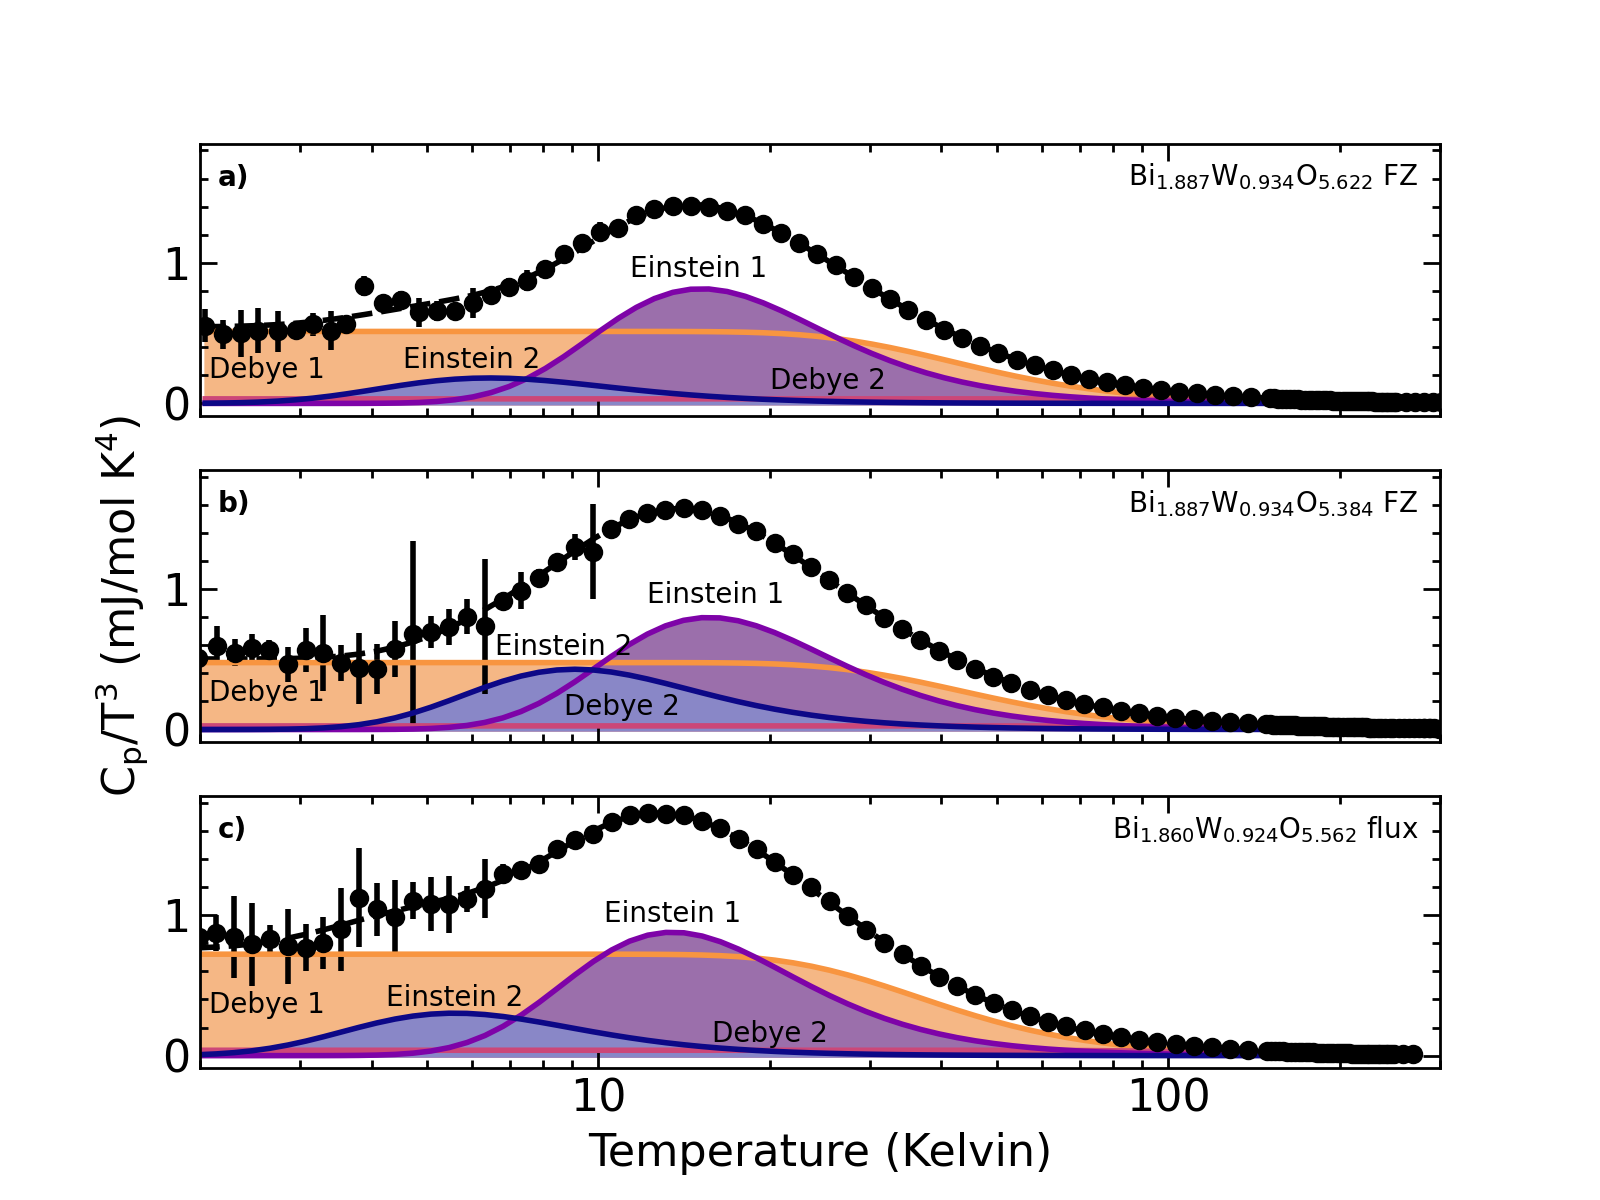

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.style.use(['science','notebook'])
keys = list(spectra.keys())
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True,)
#formatting to get the x axis right
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
formatter = ScalarFormatter()
formatter.set_scientific(False)
for subplot in axes:
    subplot.xaxis.set_major_formatter(formatter)
#automated plotting
i = 0
sublabel =['a)','b)','c)']
sublegend = ['Bi$_{1.887}$W$_{0.934}$O$_{5.622}$ FZ','Bi$_{1.887}$W$_{0.934}$O$_{5.384}$ FZ','Bi$_{1.860}$W$_{0.924}$O$_{5.562}$ flux']
for s in spectra:
    temp = spectra[s][0][0]
    axes[i].errorbar(temp,(spectra[s][0][1]/temp**3),yerr=3*spectra[s][0][2]/temp**3,fmt="ko") # 3-sigma error bars
        # The below change according to which function you are fitting of course.
    axes[i].plot(temp,(combined2Debye2Einstein(temp,*spectra[s][1][0])/temp**3),"k--")
    axes[i].plot(temp,(spectra[s][1][0][0]*debye(temp,spectra[s][1][0][1])/temp**3),color="#f89540")
    axes[i].fill_between(temp,spectra[s][1][0][0]*debye(temp,spectra[s][1][0][1])/temp**3,color="#f5b785")
    axes[i].plot(temp,(spectra[s][1][0][2]*debye(temp,spectra[s][1][0][3])/temp**3),color="#cc4778")
    axes[i].fill_between(spectra[s][0][0],spectra[s][1][0][2]*debye(spectra[s][0][0],spectra[s][1][0][3])/spectra[s][0][0]**3,color="#cc86a1")
    axes[i].plot(temp,spectra[s][1][0][4]*einstein(temp,spectra[s][1][0][5])/temp**3,color="#7e03a8")
    axes[i].fill_between(temp,spectra[s][1][0][4]*einstein(temp,spectra[s][1][0][5])/temp**3,color="#9b6fab")
    axes[i].plot(temp,spectra[s][1][0][6]*einstein(temp,spectra[s][1][0][7])/temp**3,color="#0d0887")
    axes[i].fill_between(temp,spectra[s][1][0][6]*einstein(temp,spectra[s][1][0][7])/temp**3,color="#8987c7")
    axes[i].set_xlim(2,300)
#make y units in mJ instead of J
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    axes[i].yaxis.set_major_formatter(ticks_y)
#labeling
    axes[i].text(2.15,0.00155,sublabel[i], fontweight = 'bold')
    axes[i].text(275,0.00155,sublegend[i], horizontalalignment = 'right')
    i += 1
axes[2].set_xlabel("Temperature (Kelvin)")
axes[1].set_ylabel("$\mathrm{C_p/T^3}$ (mJ/mol K$^4$)")
#labeling different modes (need to individually since they are slightly off)
axes[0].text(15,0.0009,'Einstein 1',horizontalalignment = 'center')
axes[1].text(16.05,0.0009,'Einstein 1',horizontalalignment = 'center')
axes[2].text(13.5,0.00095,'Einstein 1',horizontalalignment = 'center')
axes[0].text(2.07,0.00018,'Debye 1',horizontalalignment = 'left')
axes[1].text(2.07,0.0002,'Debye 1',horizontalalignment = 'left')
axes[2].text(2.07,0.0003,'Debye 1',horizontalalignment = 'left')
axes[0].text(6,0.00025,'Einstein 2',horizontalalignment = 'center')
axes[1].text(8.7,0.00053,'Einstein 2',horizontalalignment = 'center')
axes[2].text(5.6,0.00035,'Einstein 2',horizontalalignment = 'center')
axes[0].text(20,0.0001,'Debye 2',horizontalalignment = 'left')
axes[1].text(11,0.0001,'Debye 2',horizontalalignment = 'center')
axes[2].text(20,0.0001,'Debye 2',horizontalalignment = 'center')
fig.savefig('Heat-Capacity-updated20230830', dpi = 300)